In [13]:
import pandas as pd
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import os
import argparse

def split_tissue(input_pipeline, spatial_coords, n, figure=True, output_dir='output_files'):
    ''' 
        Splits tissue samples into a grid of n*n parts based on the spatial coordinates of the spots. 
        This function generates n*n AnnData objects, an updated AnnData object with assigned parts, a CSV file containing the spots in each part, and optionally a figure showing the distribution of spots across the parts.

        Args:
            input_pipeline (str): File path to an AnnData object stored in .h5ad format, containing data for the spots.
            spatial_coords (str): File path to a CSV file with 6 columns: 'spot_id', 'tissue', 'x0', 'y0', 'x', 'y', which define the spatial coordinates of the spots.
            n (int): The number of divisions per dimension, with the tissue being split into an n*n grid of parts.
            figure (bool, optional): If `True`, a figure will be displayed showing the distribution of spots across the parts (default is `True`).
            output_dir (str, optional): Directory where the output files will be saved (default is 'output_files').

        Returns:
            None: The function saves the updated AnnData objects as .h5ad files, generates a CSV file with the spots' part assignments, 
            and shows a figure if `figure=True`.

        Notes:
            - The parts are numbered from 0 to n*n-1. Part 0 contains the spots with the smallest x and y coordinates, part 1 contains the spots with the smallest x and the second smallest y coordinates, and so on.
            - The function divides the spots evenly across the n*n grid based on their spatial coordinates.
            - It checks whether all spots from the `input_pipeline` file are present in the `spatial_coords` dataset.
            
        Requirements:
            - The function requires the following libraries to be installed: pandas, numpy, scanpy, matplotlib.
    '''

    # Create the output directory if it doesn't exist, and overwrite if it exists
    if os.path.exists(output_dir):
        # Remove existing files in the output directory before saving new ones
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        os.makedirs(output_dir)

    # Load data
    spatial_coords = pd.read_csv(spatial_coords, delimiter=',', names=['spot_id', 'tissue', 'x0', 'y0', 'x', 'y'])
    input_pipeline = sc.read_h5ad(input_pipeline)
    input_pipeline.obs['part'] = np.nan
    print(input_pipeline.__dict__['_raw'])

    # Check whether all spots in the input_pipeline file are present in the spatial_coords file
    if not input_pipeline.obs.index.str[:-2].isin(spatial_coords['spot_id']).all():
        print('Not all spots are present in the spatial_coords file')
        return None
    
    # Filter the spatial_coords file to only include the spots present in the input_pipeline file
    common_spots = input_pipeline.obs.index.str[:-2].intersection(spatial_coords.iloc[:,0])
    spatial_coords_filtered = spatial_coords[spatial_coords['spot_id'].isin(common_spots)]

    # Initialize part column with -1
    count = 0

    # Sort the spots by x and y coordinates
    sorted_spots_x = spatial_coords_filtered.sort_values(['x0', 'y0'])

    # Split the x and y coordinates into n equal parts
    x_bins = np.array_split(sorted_spots_x, n, axis=0)

    # Iterate through the bins to assign parts
    for i in range(n):
        x_subset = x_bins[i]

        # Sort the subset by y and x for the next step
        sorted_subset_y = x_subset.sort_values(['y', 'x'])
        y_bins = np.array_split(sorted_subset_y, n, axis=0)

        for j in range(n):            
            # Get the spot ids that belong to this part
            q = y_bins[j]['spot_id']

            # Update the 'part' values in both input_pipeline and spatial_coords_filtered
            input_pipeline.obs.loc[input_pipeline.obs.index.str[:-2].isin(q), 'part'] = count
            spatial_coords_filtered.loc[spatial_coords_filtered['spot_id'].isin(q), 'part'] = count
            count += 1

    # Control whether all spots are assigned to a part
    if sum(pd.isna(input_pipeline.obs['part'])) > 0:
        print('Not all spots are assigned to a part')
    else:
        print('All spots are assigned to a part')

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Write the updated AnnData object (AnnData object, containing the parts) to a .h5ad file
    input_pipeline.__dict__['_raw'].__dict__['_var'] = input_pipeline.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})  # Needed otherwise there is a conflict
 
 
    file_name2 = os.path.join(output_dir, "updated_annData_obj.h5ad")
    print(type(input_pipeline))
    input_pipeline.write(filename=file_name2)
    print(f"Saved updated AnnData object to {file_name2}")

    # Create a CSV file with the part each spot belongs to
    df = pd.DataFrame(input_pipeline.obs['part'])
    df.index = input_pipeline.obs['part'].index
    csv_file = os.path.join(output_dir, "spots_and_parts.csv")
    df.to_csv(csv_file)
    print(f"Saved the index of the spots in each part to {csv_file}")

    # Create a new AnnData object for each part
    for part_value in sorted(input_pipeline.obs['part'].unique()):
        part_data = input_pipeline[input_pipeline.obs['part'] == part_value]
        part_data.obs = part_data.obs.drop(columns=["part"])
    
        # Save each part as a separate .h5ad file
        part_file_name = os.path.join(output_dir, f"annData_part_{part_value}.h5ad")
        part_data.write(filename=part_file_name)
        print(f"Saved AnnData object for part {part_value} to {part_file_name}")


    if figure == True:
        # Calculate the count for each part
        part_counts = input_pipeline.obs['part'].value_counts()

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 5))

        # Create the bar plot
        bars = ax.bar(sorted(part_counts.index.astype(str)), part_counts.values, color='salmon')

        # Set labels and title
        ax.set_xlabel('Part')
        ax.set_ylabel('Number of spots')
        ax.set_title('Distribution of spots across parts')
        ax.set_xticks(sorted(part_counts.index.astype(int)))
        ax.set_xticklabels(sorted(part_counts.index.astype(int)))

        # Display the height of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, str(int(yval)), ha='center', va='bottom')

        # Show the plot
        plt.show()

    print(input_pipeline.obs['part'])

    return None

In [14]:
input_pipeline = 'liver_mouseVisium_JB01.h5ad'
spatial_coords = 'GSM5764414_tissue_positions_list_JBO001.csv'
n = 2

Raw AnnData with n_obs × n_vars = 1293 × 31053
    var: '_index'
All spots are assigned to a part
<class 'anndata._core.anndata.AnnData'>


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_4143/1612246782.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_coords_filtered.loc[spatial_coords_filtered['spot_id'].isin(q), 'part'] = count
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Saved updated AnnData object to output_files/updated_annData_obj.h5ad
Saved the index of the spots in each part to output_files/spots_and_parts.csv
Saved AnnData object for part 0.0 to output_files/annData_part_0.0.h5ad
Saved AnnData object for part 1.0 to output_files/annData_part_1.0.h5ad
Saved AnnData object for part 2.0 to output_files/annData_part_2.0.h5ad
Saved AnnData object for part 3.0 to output_files/annData_part_3.0.h5ad


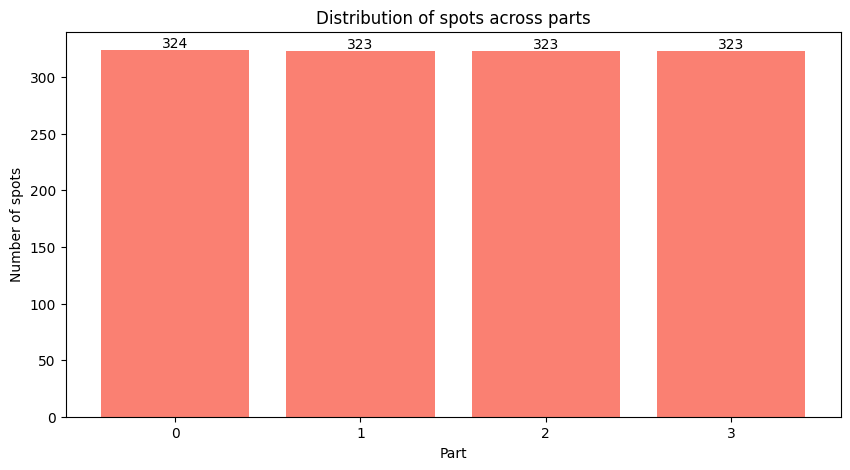

AAACACCAATAACTGC-1_1    2.0
AAACATTTCCCGGATT-1_1    3.0
AAACCCGAACGAAATC-1_1    1.0
AAACCGGGTAGGTACC-1_1    0.0
AAACCGTTCGTCCAGG-1_1    2.0
                       ... 
TTGTGGTGGTACTAAG-1_1    3.0
TTGTGTATGCCACCAA-1_1    2.0
TTGTTGTGTGTCAAGA-1_1    1.0
TTGTTTCATTAGTCTA-1_1    2.0
TTGTTTCCATACAACT-1_1    0.0
Name: part, Length: 1293, dtype: float64


In [4]:
split_tissue(input_pipeline,spatial_coords,n)


In [ ]:
# comparison of annData objects
import scanpy as sc
import pprint


def repr_dict(adata):
    d = {}
    for attr in (
        "n_obs",
        "n_vars",
        "obs",
        "var",
        "uns",
        "obsm",
        "varm",
        "layers",
        "obsp",
        "varp",
    ):
        got_attr = getattr(adata, attr)
        if isinstance(got_attr, int):
            d[attr] = got_attr
        else:
            keys = list(got_attr.keys())
            if keys:
                d[attr] = keys
    return d


AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
{'n_obs': 700,
 'n_vars': 765,
 'obs': ['bulk_labels',
         'n_genes',
         'percent_mito',
         'n_counts',
         'S_score',
         'G2M_score',
         'phase',
         'louvain'],
 'obsm': ['X_pca', 'X_umap'],
 'obsp': ['distances', 'connectivities'],
 'uns': ['bulk_labels_colors',
         'louvain',
         'louvain_colors',
         'neighbors',
         'pca',
         'rank_genes_groups'],
 'var': ['n_counts',
         'means',
         'dispersions',
         'dispersions_norm',
         'highly_variable'],
 'varm': ['PCs']}


In [34]:
#spatial_coords = pd.read_csv('GSM5764414_tissue_positions_list_JBO001.csv', delimiter=',', names=['spot_id', 'tissue', 'x0', 'y0', 'x', 'y'])
input_pipeline = sc.read_h5ad('liver_mouseVisium_JB01.h5ad')
output = sc.read_h5ad('annData_part_0.0.h5ad')
updated = sc.read_h5ad('updated_annData_obj.h5ad')
#print(input_pipeline)
#print(output)
#inp2 = sc.read_10x_h5('filtered_feature_bc_matrix.h5')

In [35]:
print(input_pipeline)
#print(output.X)
#pprint.pprint(repr_dict(input_pipeline))

AnnData object with n_obs × n_vars = 1293 × 31053
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'UMAP_1', 'UMAP_2', 'sample', 'type', 'cluster', 'zonation', 'zonationGroup'
    var: 'features'


In [12]:
print(updated)
pprint.pprint(repr_dict(updated))

AnnData object with n_obs × n_vars = 1293 × 31053
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'UMAP_1', 'UMAP_2', 'sample', 'type', 'cluster', 'zonation', 'zonationGroup', 'part'
    var: 'features'
{'n_obs': 1293,
 'n_vars': 31053,
 'obs': ['orig.ident',
         'nCount_Spatial',
         'nFeature_Spatial',
         'UMAP_1',
         'UMAP_2',
         'sample',
         'type',
         'cluster',
         'zonation',
         'zonationGroup',
         'part'],
 'var': ['features']}


In [ ]:
print(output.obs.columns)  # Alle kolommen in de cellenmetadata
print(output.var.columns)  # Alle kolommen in de genenmetadata
print(output.uns.keys())  # Ongeordende metadata
print(output.layers.keys())  # Beschikbare lagen met expressiewaarden

bdata =  output




Index(['orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'UMAP_1', 'UMAP_2',
       'sample', 'type', 'cluster', 'zonation', 'zonationGroup'],
      dtype='object')
Index(['features'], dtype='object')
odict_keys([])
KeysView(Layers with keys: )
(324, 31053)
                      orig.ident  nCount_Spatial  nFeature_Spatial    UMAP_1  \
AAACCGGGTAGGTACC-1_1           0         46259.0              5326 -4.557705   
AAACTGCTGGCTCCAA-1_1           0         35257.0              4742 -4.124313   
AAATACCTATAAGCAT-1_1           0         33646.0              4848  0.615303   
AAATCGTGTACCACAA-1_1           0         39464.0              5036  2.947431   
AAATTAACGGGTAGCT-1_1           0         48521.0              5410 -2.084130   
...                          ...             ...               ...       ...   
TTGGACATGTGGCTTA-1_1           0         37471.0              4905 -3.179777   
TTGGATATCGTCTACG-1_1           0         31205.0              4499 -3.949710   
TTGGTCACACTCGTAA-1_1

In [ ]:
#print(input_pipeline.obs.columns)  # Alle kolommen in de cellenmetadata
#print(input_pipeline.var.columns)  # Alle kolommen in de genenmetadata
#print(input_pipeline.uns.keys())  # Ongeordende metadata
#print(input_pipeline.layers.keys())  # Beschikbare lagen met expressiewaarden

adata = input_pipeline

#print(adata.shape) # (aantal cellen, aantal genen)
#print(bdata.shape) # (aantal cellen, aantal genen)
#print(adata.obs ) # Metadata over de cellen (pandas DataFrame)
#print(bdata.obs ) # Metadata over de cellen (pandas DataFrame)
#print(adata.var)  # Metadata over de genen (pandas DataFrame)
#print(bdata.var)  # Metadata over de genen (pandas DataFrame)
#print(adata.X)  # De expressiematrix (meestal een NumPy-array of sparse matrix)
#print('-'*50)
#print(bdata.X)  # De expressiematrix (meestal een NumPy-array of sparse matrix)
print(adata.raw)  # Ruwe expressiewaarden (indien aanwezig)  => hier zit de fout
print(bdata.raw)  # Ruwe expressiewaarden (indien aanwezig)
#print(adata.layers)  # Verschillende datalagen (bv. genormaliseerde vs ruwe data)
#print(bdata.layers)  # Verschillende datalagen (bv. genormaliseerde vs ruwe data)
#print(adata.obsm)  # Lage-dimensionale representaties (bv. PCA, UMAP)
#print(bdata.obsm)  # Lage-dimensionale representaties (bv. PCA, UMAP)
#print(adata.uns)  # Niet-gestructureerde metadata (bv. clusteringresultaten)
#print(bdata.uns)  # Niet-gestructureerde metadata (bv. clusteringresultaten)

print(adata.raw)  # Ruwe expressiewaarden (indien aanwezig)  => hier zit de fout (original)
print(bdata.raw) #updated

Raw AnnData with n_obs × n_vars = 1293 × 31053
    var: '_index'
Raw AnnData with n_obs × n_vars = 324 × 31053
    var: 'features'


In [4]:
input_pipeline_a = 'filtered_feature_bc_matrix.h5'
spatial_coords_a = 'tissue-positions.csv'

In [ ]:
def split_tissue(input_pipeline_a, spatial_coords_a, n, figure=True, output_dir='output_files'):
    ''' 
        Splits tissue samples into a grid of n*n parts based on the spatial coordinates of the spots. 
        This function generates n*n AnnData objects, an updated AnnData object with assigned parts, a CSV file containing the spots in each part, and optionally a figure showing the distribution of spots across the parts.

        Args:
            input_pipeline (str): File path to an AnnData object stored in .h5ad format or .h5 format, containing data for the spots.
            spatial_coords (str): File path to a CSV file with 6 columns: 'spot_id', 'tissue', 'x0', 'y0', 'x', 'y', which define the spatial coordinates of the spots.
            n (int): The number of divisions per dimension, with the tissue being split into an n*n grid of parts.
            figure (bool, optional): If `True`, a figure will be displayed showing the distribution of spots across the parts (default is `True`).
            output_dir (str, optional): Directory where the output files will be saved (default is 'output_files').

        Returns:
            None: The function saves the updated AnnData objects as .h5ad files, generates a CSV file with the spots' part assignments, 
            and shows a figure if `figure=True`.

        Notes:
            - The parts are numbered from 0 to n*n-1. Part 0 contains the spots with the smallest x and y coordinates, part 1 contains the spots with the smallest x and the second smallest y coordinates, and so on.
            - The function divides the spots evenly across the n*n grid based on their spatial coordinates.
            - It checks whether all spots from the `input_pipeline` file are present in the `spatial_coords` dataset.
            
        Requirements:
            - The function requires the following libraries to be installed: pandas, numpy, scanpy, matplotlib.
    '''

    # Create the output directory if it doesn't exist, and overwrite if it exists
    if os.path.exists(output_dir):
        # Remove existing files in the output directory before saving new ones
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        os.makedirs(output_dir)

    # Load data
    spatial_coords = pd.read_csv(spatial_coords_a, delimiter=',', names=['spot_id', 'tissue', 'x0', 'y0', 'x', 'y'])
    if input_pipeline_a.endswith('.h5ad'):
        input_pipeline = sc.read_h5ad(input_pipeline_a)
    elif input_pipeline_a.endswith('.h5'):
        input_pipeline = sc.read_10x_h5(input_pipeline_a)
    else:
        print('Invalid file format for input_pipeline')
        return None
    input_pipeline.obs['part'] = np.nan

    # Check whether all spots in the input_pipeline file are present in the spatial_coords file
    if input_pipeline_a.endswith('.h5ad'):
        if not input_pipeline.obs.index.str[:-2].isin(spatial_coords['spot_id']).all():
            print('Not all spots are present in the spatial_coords file')
            return None
    else:
        if not input_pipeline.obs.index.isin(spatial_coords['spot_id']).all():
            print('Not all spots are present in the spatial_coords file')
            return None
    
    # Filter the spatial_coords file to only include the spots present in the input_pipeline file
    if input_pipeline_a.endswith('.h5ad'):
        common_spots = input_pipeline.obs.index.str[:-2].intersection(spatial_coords.iloc[:,0])
    else:
        common_spots = input_pipeline.obs.index.intersection(spatial_coords.iloc[:,0])
    spatial_coords_filtered = spatial_coords[spatial_coords['spot_id'].isin(common_spots)]

    # Initialize part column with -1
    count = 0

    # Sort the spots by x and y coordinates
    sorted_spots_x = spatial_coords_filtered.sort_values(['x0', 'y0'])

    # Split the x and y coordinates into n equal parts
    x_bins = np.array_split(sorted_spots_x, n, axis=0)

    # Iterate through the bins to assign parts
    for i in range(n):
        x_subset = x_bins[i]

        # Sort the subset by y and x for the next step
        sorted_subset_y = x_subset.sort_values(['y', 'x'])
        y_bins = np.array_split(sorted_subset_y, n, axis=0)

        for j in range(n):            
            # Get the spot ids that belong to this part
            q = y_bins[j]['spot_id']

            # Update the 'part' values in both input_pipeline and spatial_coords_filtered
            if input_pipeline_a.endswith('.h5ad'):
                input_pipeline.obs.loc[input_pipeline.obs.index.str[:-2].isin(q), 'part'] = count
            else:
                input_pipeline.obs.loc[input_pipeline.obs.index.isin(q), 'part'] = count
            spatial_coords_filtered.loc[spatial_coords_filtered['spot_id'].isin(q), 'part'] = count
            count += 1

    # Control whether all spots are assigned to a part
    if sum(pd.isna(input_pipeline.obs['part'])) > 0:
        print('Not all spots are assigned to a part')
    else:
        print('All spots are assigned to a part')

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Write the updated AnnData object (AnnData object, containing the parts) to a .h5ad file
    if input_pipeline_a.endswith('.h5ad'):
        input_pipeline.__dict__['_raw'].__dict__['_var'] = input_pipeline.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
    
    output_file = "updated_file.h5ad"
    file_name2 = os.path.join(output_dir, "updated_annData_obj.h5ad")
    input_pipeline.write(filename=file_name2)
    print(f"Saved updated AnnData object to {file_name2}")

    # Create a CSV file with the part each spot belongs to
    df = pd.DataFrame(input_pipeline.obs['part'])
    df.index = input_pipeline.obs['part'].index
    csv_file = os.path.join(output_dir, "spots_and_parts.csv")
    df.to_csv(csv_file)
    print(f"Saved the index of the spots in each part to {csv_file}")

    # Create a new AnnData object for each part
    for part_value in sorted(input_pipeline.obs['part'].unique()):
        part_data = input_pipeline[input_pipeline.obs['part'] == part_value]
        part_data.obs = part_data.obs.drop(columns=["part"])
    
        # Save each part as a separate .h5ad file
        part_file_name = os.path.join(output_dir, f"annData_part_{int(part_value)}.h5ad")
        part_data.write(filename=part_file_name)
        print(f"Saved AnnData object for part {part_value} to {part_file_name}")


    if figure == True:
        # Calculate the count for each part
        part_counts = input_pipeline.obs['part'].value_counts()

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 5))

        # Create the bar plot
        bars = ax.bar(sorted(part_counts.index.astype(str)), part_counts.values, color='salmon')

        # Set labels and title
        ax.set_xlabel('Part')
        ax.set_ylabel('Number of spots')
        ax.set_title('Distribution of spots across parts')
        ax.set_xticks(sorted(part_counts.index.astype(int)))
        ax.set_xticklabels(sorted(part_counts.index.astype(int)))

        # Display the height of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, str(int(yval)), ha='center', va='bottom')

        # Save the figure
        plt.savefig("distribution_plot.png", dpi=300, bbox_inches='tight')

    return None

/tmp/ipykernel_11984/3846705391.py:37: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  spatial_coords = pd.read_csv(spatial_coords_a, delimiter=',', names=['spot_id', 'tissue', 'x0', 'y0', 'x', 'y'])
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/sarah/a

All spots are assigned to a part
Saved updated AnnData object to output_files/updated_annData_obj.h5ad
Saved the index of the spots in each part to output_files/spots_and_parts.csv
0.0


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved AnnData object for part 0.0 to output_files/annData_part_0.0.h5ad
1.0


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved AnnData object for part 1.0 to output_files/annData_part_1.0.h5ad
2.0


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved AnnData object for part 2.0 to output_files/annData_part_2.0.h5ad
3.0


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved AnnData object for part 3.0 to output_files/annData_part_3.0.h5ad


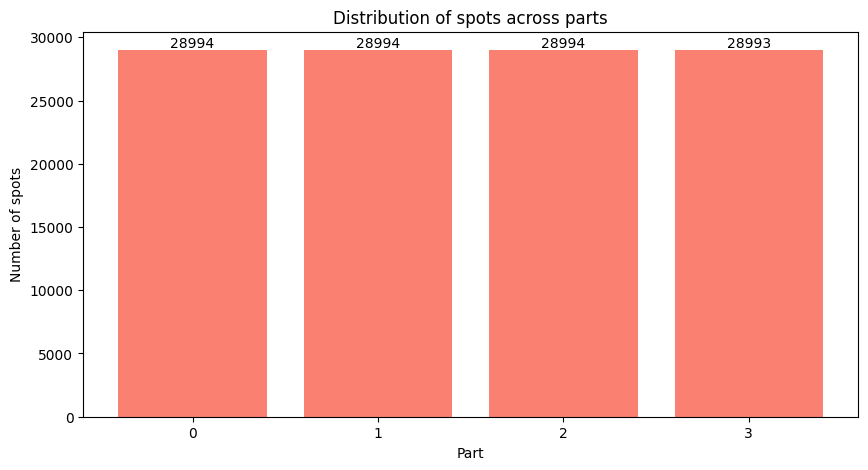

In [8]:
split_tissue(input_pipeline_a,spatial_coords_a,2)

In [21]:
input_pipeline = sc.read_10x_h5(input_pipeline_a)
print(input_pipeline.obs.index.dtype)

/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


object


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [32]:
print(input_pipeline.obs.index.unique())
print(input_pipeline._dict_)

Index(['s_016um_00052_00082-1', 's_016um_00163_00399-1',
       's_016um_00238_00388-1', 's_016um_00144_00175-1',
       's_016um_00297_00147-1', 's_016um_00252_00390-1',
       's_016um_00225_00065-1', 's_016um_00036_00081-1',
       's_016um_00188_00060-1', 's_016um_00135_00034-1',
       ...
       's_016um_00297_00243-1', 's_016um_00267_00226-1',
       's_016um_00267_00377-1', 's_016um_00231_00291-1',
       's_016um_00202_00345-1', 's_016um_00212_00331-1',
       's_016um_00288_00288-1', 's_016um_00193_00227-1',
       's_016um_00109_00223-1', 's_016um_00144_00329-1'],
      dtype='object', length=115975)


AttributeError: 'AnnData' object has no attribute '_dict_'